<div class="alert alert-danger" style="color:black"><b>Running ML-LV Jupyter Notebooks:</b><br>
    <ol>
        <li>Make sure you are running all notebooks using the <code>adv_ai</code> kernel.
        <li><b>It is very important that you do not create any additional files within the weekly folders on CSCT cloud.</b> Any additional files, or editing the notebooks with a different environment may prevent submission/marking of your work.</li>
            <ul>
                <li>NBGrader will automatically fetch and create the correct folders files for you.</li>
                <li>All files that are not the Jupyter notebooks should be stored in the 'ML-LV/data' directory.</li>
            </ul>
        <li>Please <b>do not pip install</b> any python packages (or anything else). You should not need to install anything to complete these notebooks other than the packages provided in the Jupyter CSCT Cloud environment.</li>
    </ol>
    <b>If you would like to run this notebook locally you should:</b><br>
    <ol>
        <li>Create an environment using the requirements.txt file provided. <b>Any additional packages you install will not be accessible when uploaded to the server and may prevent marking.</b></li>
        <li>Download a copy  of the notebook to your own machine. You can then edit the cells as you wish and then go back and copy the code into/edit the ones on the CSCT cloud in-place.</li>
        <li><b>It is very important that you do not re-upload any notebooks that you have edited locally.</b> This is because NBGrader uses cell metadata to track marked tasks. <b>If you change this format it may prevent marking.</b></li>
    </ol>
</div>

# Practical 6: Attention and Transformers

A typical Seq2seq model is limited by fixed size input and output vectors. For many tasks, such as Machine Translation (MT), text summarisation and generating text with a language model, we may wish to output different size sequences. The performance of Seq2seq models may also be limited by the single fixed-size context vector produced by the encoder, which reduces the amount of information passed to the decoder. The attention mechanism aims to solve these issues. Instead of encoding a single context vector the encoder produces a *sequence* of vectors, one for each timestep of the input. The attention mechanism then allows the decoder to 'pay attention' to the important important inputs and ignore less important ones.

Although attention mechanisms often result in a significant performance boost on many task, the recurrent nature of Seq2seq architecture means it is slow to train. To overcome this issue Vaswani, A. et al. (2017) proposed a new architecture, the Transformer, which throws away recurrence and focuses only on attention. [Attention is all you need!](https://proceedings.neurips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf). Transformers have since become the basis for nearly all state-of-the-art models for language modelling, classification, MT, summarisation and many other NLP tasks.

In the first part of this practical we will create a Seq2seq model with attention for MT. The MT model will be trained to translate English sentences into French with an [English to French](http://www.manythings.org/anki/) dataset. Once trained, we will be able to translate English phrases and visualise the weights of the attention mechanism to understand which English words were 'attended to' in order to produce the translation.

In the second part of this practical we will create a Transformer-based translator by fine-tuning an existing model, the [T5](https://arxiv.org/abs/1910.10683v3), on our translation dataset.

The objectives of this practical are:
1. Understand how Seq2seq architecture and attention mechanisms work, and help the model to identify the important features of input sequences

2. Introduce a new ML library, Hugging Face 🤗 Transformers that is useful for building and fine-tuning large Transformer models

3. Compare and contrast recurrent Seq2seq with attention to a transfer learning approach using a large pre-trained language model (T5), based on Transformer architecture, for MT

# 1 Translation with Seq2Seq and Attention

## 1.0 Import libraries

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress Tensorflow messages
os.environ["TF_USE_LEGACY_KERAS"] = "1"  # Use legacy keras for compatibility
import re
import unicodedata
import pickle
import nltk
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import tensorflow as tf
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from nltk.translate import meteor
from tensorflow.keras import layers
from tensorflow.keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
%matplotlib inline

# Get the status of NBgrader (for skipping cell execution while validating/grading)
grading = True if os.getenv('NBGRADER_EXECUTION') else False

# Set seaborn style for matplotlib plots
plt.style.use('seaborn-v0_8-white')

# Get the project directory (should be in ML-LV)
path = ''
while os.path.basename(os.path.abspath(path)) != 'ML-LV':
    path = os.path.abspath(os.path.join(path, '..'))

# Set the directory to the data folder (should be in ML-LV/data)
data_dir = os.path.join(path, 'data')

# Set the directory to the shared dataset folder (should be in shared/datasets/translate)
dataset_dir = os.path.join(path, '..', 'shared', 'datasets', 'translate')

# Set the directory to the shared models folder (should be in shared/models/translate)
model_dir = os.path.join(path, '..', 'shared', 'models', 'translate')

# Set the nltk data directory (should be in shared/datasets/nltk_data)
nltk.data.path.append(os.path.join(dataset_dir, '..', 'nltk_data'))

## 1.1 Load and pre-process data

The data directory should contain the English and French text file. We will simply loop over the file and separate the English and French phrases. Then perform some simple normalisation by removing accents from the french words and keeping only basic punctuation symbols (.,!? and '), and then tokenise and remove extra whitespace.

In [12]:
def preprocess_sentence(sentence):
    # Remove accents
    sentence = unicodedata.normalize('NFD', sentence).encode('ascii', 'ignore')
    # Convert back to unicode
    sentence = sentence.decode('UTF-8')

    # Replace everything with space except (a-z, A-Z, ".", "?", "!", "'", ",")
    sentence = re.sub(r"[^a-zA-Z?.!',¿]+", " ", sentence)

    # Create a space between word and the punctuation following it
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)

    # Lowercase and remove leading/trailing spaces
    sentence = sentence.lower().strip()

    # Tokenize
    tokens = sentence.split()

    return tokens

if not grading:
    # Preprocess the English and French sentences
    eng_corpus = []
    fr_corpus = []
    with open(os.path.join(dataset_dir, 'english-french.txt'), 'r', encoding='utf-8') as file:
        text = file.read().splitlines()

        for line in text:
            # Split the line into English and French
            line = line.split('\t')

            # Add to corpus
            eng_corpus.append(preprocess_sentence(line[0]))
            fr_corpus.append(preprocess_sentence(line[1]))

    print(f"Number of English sentences: {len(eng_corpus)}")
    print(f"Number of French sentences: {len(fr_corpus)}")
    print("First 5 sentences: ")
    for i in range(5):
        print(' '.join(eng_corpus[i]) + ' -> ' + ' '.join(fr_corpus[i]))

Number of English sentences: 197463
Number of French sentences: 197463
First 5 sentences: 
go . -> va !
go . -> marche .
go . -> en route !
go . -> bouge !
hi . -> salut !


### Plot sequence lengths

We can plot the distribution of sentence lengths to determine how long the input sequences should be.
It looks like sequences of ~20 should be a suitable `max_seq_len`.

Mean sequence length: 7.147 (English), 7.703 (French)
Median sequence length: 7.0 (English), 7.000 (French)
Max sequence length: 52 (English), 59 (French)


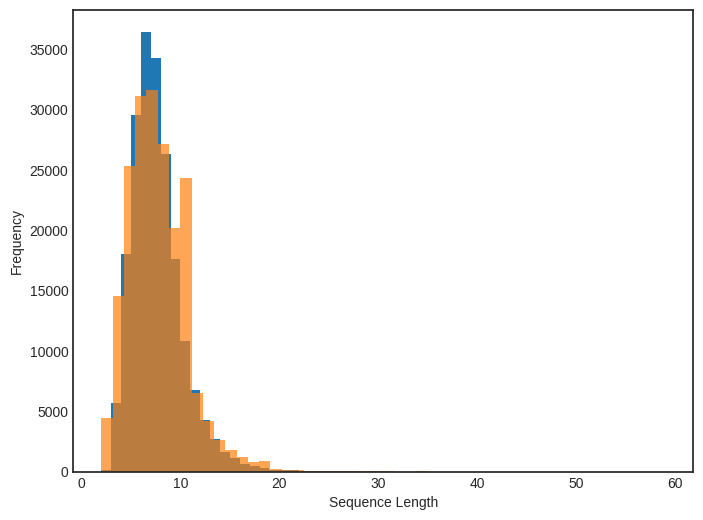

In [3]:
# Get the sequence lengths
eng_seq_lengths = [len(sent) for sent in eng_corpus]
fr_seq_lengths = [len(sent) for sent in fr_corpus]

print(f"Mean sequence length: {np.mean(eng_seq_lengths):.3f} (English), {np.mean(fr_seq_lengths):.3f} (French)")
print(f"Median sequence length: {np.median(eng_seq_lengths)} (English), {np.median(fr_seq_lengths):.3f} (French)")
print(f"Max sequence length: {np.max(eng_seq_lengths)} (English), {np.max(fr_seq_lengths)} (French)")

# Plot the distribution of sentence lengths
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(eng_seq_lengths, bins=50)
ax.hist(fr_seq_lengths, bins=50, alpha=0.7)
ax.set_xlabel('Sequence Length')
ax.set_ylabel('Frequency')
plt.show()

### Load a vocabulary

Load a vocabulary as before, for both English and French. As with language modelling, increasing the vocabulary size greatly increases the complexity of the task, because each output prediction is a word from the vocabulary. However, if either vocabulary is too small the model will not be able to learn a complete mapping between the words, so we will keep all words in the vocabulary.

In [4]:
# Load the vocabulary files and store each word in a list
with open(os.path.join(model_dir, 'eng_vocab.txt'), 'r') as file:
    eng_vocab = file.read().splitlines()

with open(os.path.join(model_dir, 'fr_vocab.txt'), 'r') as file:
    fr_vocab = file.read().splitlines()

# Print the vocabulary
print(f"English vocabulary size: {len(eng_vocab)}")
for i, word in enumerate(eng_vocab[:50]):
    print(f'({str(i)}, {word})', end=' ')
print()
print(f"French vocabulary size: {len(fr_vocab)}")
for i, word in enumerate(fr_vocab[:50]):
    print(f'({str(i)}, {word})', end=' ')

English vocabulary size: 15722
(0, <pad>) (1, <unk>) (2, <s>) (3, </s>) (4, .) (5, i) (6, you) (7, to) (8, the) (9, ?) (10, a) (11, is) (12, tom) (13, that) (14, do) (15, of) (16, it) (17, he) (18, this) (19, in) (20, me) (21, don't) (22, have) (23, ,) (24, was) (25, my) (26, for) (27, i'm) (28, your) (29, are) (30, what) (31, we) (32, be) (33, want) (34, not) (35, know) (36, she) (37, like) (38, on) (39, with) (40, can) (41, you're) (42, did) (43, at) (44, all) (45, how) (46, his) (47, think) (48, go) (49, they) 
French vocabulary size: 27962
(0, <pad>) (1, <unk>) (2, <s>) (3, </s>) (4, .) (5, je) (6, de) (7, a) (8, ?) (9, pas) (10, vous) (11, que) (12, la) (13, ne) (14, le) (15, tu) (16, il) (17, tom) (18, est) (19, ce) (20, ,) (21, un) (22, nous) (23, les) (24, en) (25, une) (26, j'ai) (27, suis) (28, pour) (29, me) (30, faire) (31, c'est) (32, ca) (33, elle) (34, !) (35, des) (36, dans) (37, plus) (38, du) (39, qui) (40, moi) (41, tout) (42, te) (43, veux) (44, fait) (45, avec) (46

## 1.2 Create a data generator

As with language modelling, the number of inputs required for training is larger than the number of phrase pairs in the data, so we will use a Generator class to feed data into the model. For each input/output pair we need to generate:

1. Encoder inputs, the English phrase

2. Decoder inputs, the French phrase including the `<s>` token, but not including the `</s>` token (so the decoder has the context vector(s) and a token to start generating from)

3. Decoder outputs, the French phrase including the `</s>` token, but not including the `<s>` token (so the decoder learns to generate output until the `</s>` token is reached)

<div class="alert alert-success" style="color:black"><b>Note:</b> We could perform all pre-processing within the data generator, such as tokenisation and lowercasing. However, for simplicity and to allow the creation of a vocabulary, here we only preform the step which greatly decrease memory requirements.</div>

In [5]:
class MTDataGenerator(tf.keras.utils.Sequence):
    """Custom data generator for machine translation."""

    def __init__(self, in_data, out_data, in_vocab, out_vocab, max_seq_len, batch_size, shuffle=True, **kwargs):
        """Constructor for data generator.
        
        Arguments:
            in_data (list): List of input sentences
            out_data (list): List of output sentences
            in_vocab (list): List of input vocabulary
            out_vocab (list): List of output vocabulary
            max_seq_len (int): Maximum sequence length
            batch_size (int): Batch size
            shuffle (bool): Whether to shuffle the data after each epoch
        """
        super().__init__(**kwargs)
        
        self.in_data = in_data
        self.out_data = out_data
        self.in_vocab = in_vocab
        self.out_vocab = out_vocab

        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.shuffle = shuffle

        # Get the data indexes and shuffle
        self.indexes = np.arange(len(self.in_data))
        self.on_epoch_end()
    
    def on_epoch_end(self):
        """Updates data after each epoch. Currently only shuffles data if shuffle=True."""
        if self.shuffle:
            np.random.shuffle(self.indexes)
        
    def __len__(self):
        """Calculates the number of batches per epoch (num_sent / batch_size)."""
        return int(np.ceil(len(self.in_data) / self.batch_size))

    def __getitem__(self, index):
        """Generates a batch of data."""

        # Generate batch of inputs and outputs
        batch_enc_inputs, batch_dec_inputs, batch_outputs = [], [], []

        # Generate indexes of the batch
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        for ind in batch_indexes:

            # Get the sentence
            in_sent = self.in_data[ind]
            out_sent = self.out_data[ind]
            
            # Vectorise the sentences
            in_sent_vector = [self.in_vocab.index(word) if word in self.in_vocab else self.in_vocab.index('<unk>') for word in in_sent]
            out_sent_vector = [self.out_vocab.index(word) if word in self.out_vocab else self.out_vocab.index('<unk>') for word in out_sent]

            # Add the start and end tokens
            in_sent_vector = [self.in_vocab.index('<s>')] + in_sent_vector + [self.in_vocab.index('</s>')]
            out_sent_vector = [self.out_vocab.index('<s>')] + out_sent_vector + [self.out_vocab.index('</s>')]

            # Add the sentences to the batch
            batch_enc_inputs.append(in_sent_vector)
            batch_dec_inputs.append(out_sent_vector[:-1])
            batch_outputs.append(out_sent_vector[1:])

        # Pad the sentences to the max_seq_len
        batch_enc_inputs = pad_sequences(batch_enc_inputs, maxlen=self.max_seq_len, padding='post', truncating='post', value=0.0)
        batch_dec_inputs = pad_sequences(batch_dec_inputs, maxlen=self.max_seq_len, padding='post', truncating='post', value=0.0)
        batch_outputs = pad_sequences(batch_outputs, maxlen=self.max_seq_len, padding='post', truncating='post', value=0.0)

        # Convert input/outputs to numpy arrays
        batch_enc_inputs = np.array(batch_enc_inputs)
        batch_dec_inputs = np.array(batch_dec_inputs)
        batch_outputs = np.array(batch_outputs)

        return (batch_enc_inputs, batch_dec_inputs), batch_outputs

# Set the maximum sequence length and batch size
max_seq_len = 20
batch_size = 128

# Create a train and validation set data generator
eng_train, eng_val, fr_train, fr_val = train_test_split(eng_corpus, fr_corpus, test_size=0.25, random_state=42)
train_generator = MTDataGenerator(eng_train, fr_train, eng_vocab, fr_vocab, max_seq_len=max_seq_len, batch_size=batch_size)
val_generator = MTDataGenerator(eng_val, fr_val, eng_vocab, fr_vocab, max_seq_len=max_seq_len, batch_size=batch_size)

# Print the number of batches
print(f"Number of training batches: {len(train_generator)}")
print(f"Number of validation batches: {len(val_generator)}")

# Print the first examples
inputs, outputs = train_generator[0]
enc_inputs, dec_inputs = inputs

print(f"Encoder input shape: {enc_inputs.shape}")
print(f"Decoder input shape: {dec_inputs.shape}")
print(f"Output shape: {outputs.shape}\n")
for i in range(3):
    print("Input Sentence: " + ' '.join([eng_vocab[word] for word in enc_inputs[i]]))
    print(f"Input Vector: {enc_inputs[i]}")
    print("Target Sentence: " + ' '.join([fr_vocab[word] for word in outputs[i]]))
    print(f"Target Vector: {outputs[i]}")
    print()

Number of training batches: 1158
Number of validation batches: 386
Encoder input shape: (128, 20)
Decoder input shape: (128, 20)
Output shape: (128, 20)

Input Sentence: <s> a known mistake is better than an unknown truth . </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Input Vector: [   2   10  688  427   11  156  110   80 3623  360    4    3    0    0
    0    0    0    0    0    0]
Target Sentence: une erreur connue est meilleure qu'une verite inconnue . </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Target Vector: [  25  455 3136   18  746  669  343 5376    4    3    0    0    0    0
    0    0    0    0    0    0]

Input Sentence: <s> it's about time i was going . </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Input Vector: [ 2 50 54 53  5 24 65  4  3  0  0  0  0  0  0  0  0  0  0  0]
Target Sentence: il est temps que j'y aille . </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Target Vector: [  16   18   

## 1.3 Build the Seq2Seq with Attention Model

The following cells define a Seq2Seq model which uses recurrent layers and an attention mechanism. Both the attention mechanism and Seq2Seq make use of subclassing, which allows us to define our own layers and model classes that inherit the behaviour of the built-in Keras layers and models.

The `BahdanauAttention` class below implements (additive) [Bahdanau style attention](https://arxiv.org/pdf/1409.0473.pdf) as a Keras layer. Attention is calculated for all inputs in a batch within the `call()` method:

1. The score is calculated with $V.tahn(W_1.h + W_2.s)$

2. The attention weights ($a$) are calculated by softmaxing the score

3. The context vector is then $\sum_{i=1}^{n}a.h$

Take some time to understand what the `BahdanauAttention` class below is doing. Particularly the `call()` method.

In [6]:
class BahdanauAttention(tf.keras.layers.Layer):
    """Bahdanau additive attention layer."""

    def __init__(self, units):
        """Constructor for attention layer.
        
        Arguments:
            units (int): Number of units
        """
        super(BahdanauAttention, self).__init__(name='BahdanauAttention')
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
    
    def call(self, query, values):
        """Forward pass for attention layer.
        
        Arguments:
            query (tf.Tensor): Query is the decoder hidden state shape=(batch_size, hidden_size)
            values (tf.Tensor): Values is the encoder output shape=(batch_size, max_seq_len, hidden_size)
        """
        # Expand for time dimension shape=(batch_size, 1, hidden_size)
        query_with_time_axis = tf.expand_dims(query, 1)

        # Calculate attention score shape=(batch_size, max_length, 1)
        score = self.V(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(values)))

        # Calculate attention weights shape=(batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # Calculate context vector shape=(batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

The `Translator` class below implements Seq2Seq with attention as a Keras model. The algorithm is implemented within the `call()` method:

1. First the inputs are encoded with the encoder layers

2. Then, for each timestep ($t$) decode the sequence:
    
    1. Calculate the context vector by applying attention to the current decoder state and encoder outputs

    2. Concatenate the context vector and decoder inputs, and pass to the decoder

    3. Generate the predicted token from the decoder outputs

<div class="alert alert-success" style="color:black"><b>Note:</b> During training the model uses <em>teacher forcing</em>, which, regardless of the predicted token, adds the actual (ground truth) token to the decoder inputs at each timestep. This is, of course, not valid during evaluation/inference, where the predicted token is appended to the decoder input for the next timestep.
</div>

The remaining functions are utility functions for generating translations with a trained model:

1. `translate()` takes a sentence (string) as input, applies the necessary pre-processing, and generates a predicted output sentence as well as an attention plot from the attention weights

2. `plot_attention()` generates a heatmap from the attention weights, which shows their magnitude with respect to each input/output token in the processed sequence

Take some time to understand what the `Translator` class below is doing. Particularly the `call()` and `translate()` methods.

In [7]:
class Translator(tf.keras.Model):
    """Sequence to sequence model with attention for machine translation."""

    def __init__(self, in_vocab, out_vocab, max_seq_len, embedding_dim, recurrent_units, attn_units):
        """Constructor for translator model.

        Arguments:
            in_vocab (list): List of English vocabulary
            out_vocab (list): List of French vocabulary
            max_seq_len (int): Maximum sequence length
            embedding_dim (int): Embedding dimension
            recurrent_units (int): Number of recurrent units
            attn_units (int): Number of attention units
        """
        super().__init__(name='Translator')

        self.in_vocab = in_vocab
        self.out_vocab = out_vocab
        self.max_seq_len = max_seq_len
        self.embedding_dim = embedding_dim
        self.recurrent_units = recurrent_units
        self.attn_units = attn_units

        # Set some empty attention weights for plotting
        self.attention_weights = None

        # Define the encoder layers
        self.enc_embedding = tf.keras.layers.Embedding(
            len(self.in_vocab),
            self.embedding_dim,
            mask_zero=True,
            name='encoder_embedding')

        self.encoder = layers.GRU(self.recurrent_units, return_sequences=True, return_state=True, dropout=0.0, name='encoder')
        
        # Define the decoder and attention layers
        self.dec_embedding = tf.keras.layers.Embedding(
            len(self.out_vocab),
            self.embedding_dim,
            mask_zero=True,
            name='decoder_embedding')

        self.attention_layer = BahdanauAttention(self.attn_units)
        
        self.decoder= layers.GRU(self.recurrent_units, return_sequences=True, return_state=True, dropout=0.0, name='decoder')
        self.decoder_dense = layers.Dense(len(self.out_vocab), activation='softmax', name='decoder_dense')

    def call(self, inputs, training=False):
        """Forward pass for translator model."""
        
        # Accumulate the decoder outputs/predictions
        all_outputs = []
        self.attention_weights = []

        # Unpack the inputs
        encoder_inputs, decoder_inputs = inputs

        # Encode the inputs
        encoder_outputs = self.enc_embedding(encoder_inputs)
        encoder_outputs, enc_state = self.encoder(encoder_outputs)

        # Set the initial decoder state to the encoder state
        dec_state = enc_state

        # Iterate over the decoder inputs one token at a time
        for t in range(self.max_seq_len):
            # Get the current decoder input
            # If training use the next decoder input (teacher forcing)
            if training:
                decoder_input = decoder_inputs[:, t]
            # Else use the predicted decoder input (i.e when using the model for inference)
            elif not training and t > 0:
                # Squash the output time dimension, shape=(batch_size, vocab_size)
                decoder_input = tf.squeeze(tf.argmax(decoder_outputs, axis=-1), axis=1) 
            # Else set the initial decoder input to the <s> token
            elif not training and t == 0:
                    current_batch_size = tf.shape(decoder_inputs)[0]
                    decoder_input = tf.fill([current_batch_size], self.out_vocab.index('<s>'))

            # Embed the decoder input, shape=(batch_size, 1, embedding_dim)
            decoder_input = self.dec_embedding(decoder_input)
            decoder_input = tf.expand_dims(decoder_input, axis=1)

            # Calculate the context vector and attention weights, shape=(batch_size, 1, attn_units)
            context_vector, curr_attn_weights = self.attention_layer(dec_state, encoder_outputs)
            context_vector = tf.expand_dims(context_vector, axis=1)

            # Store the attention weights to plot later on
            curr_attn_weights = tf.reshape(curr_attn_weights, (-1, ))
            self.attention_weights.append(curr_attn_weights)

            # Concatenate the context vector and decoder input, shape=(batch_size, 1, embedding_dim + attn_units)
            decoder_input = tf.concat([context_vector, decoder_input], axis=-1)

            # Pass the concatenated vector to the decoder
            decoder_outputs, dec_state = self.decoder(decoder_input, initial_state=dec_state)

            # Generate the predictions and append to all_outputs shape=(batch_size, 1, vocab_size)
            decoder_outputs = self.decoder_dense(decoder_outputs)

            all_outputs.append(decoder_outputs)

        # Concatenate the outputs, shape=(batch_size, max_seq_len, vocab_size)
        outputs = tf.concat(all_outputs, axis=1)

        # Stack the attention weights, shape=(batch_size, max_seq_len, max_seq_len)
        self.attention_weights = tf.stack(self.attention_weights)

        return outputs

    def translate(self, sentence):
        """Function to translate a sentence."""

        # Preprocess the sentence
        tokenised_sentence = ['<s>']  + preprocess_sentence(sentence) + ['</s>']
        
        # Vectorise and pad the sentence to the max sequence length
        encoder_input = [self.in_vocab.index(word) for word in tokenised_sentence]
        encoder_input = tf.keras.preprocessing.sequence.pad_sequences([encoder_input], maxlen=self.max_seq_len, padding='post')

        # Create the decoder input
        decoder_input = np.zeros((1, self.max_seq_len))

        # Join the encoder and decoder inputs
        inputs = (encoder_input, decoder_input)

        # Generate the predictions and attention weights
        predictions = self.call(inputs)
        attention_weights = self.attention_weights

        # Get the predicted sentence
        predicted_ids = tf.argmax(predictions[0], axis=-1).numpy()
        predicted_sentence = []
        for tkn_id in predicted_ids:
            if self.out_vocab[tkn_id] != '<pad>':
                predicted_sentence.append(self.out_vocab[tkn_id])
            if self.out_vocab[tkn_id] == '</s>':
                break
        # Above is a fix for model not behaving the same way on Juptyer CSCT cloud (even though code is the same)
        # predicted_sentence = [self.out_vocab[i] for i in predicted_ids if self.out_vocab[i] != '<pad>']

        print('Input: {}'.format(sentence))
        print('Predicted translation: {}'.format(' '.join(predicted_sentence[:-1])))

        # Only take the attention weights for the words in the sentence
        attention_weights = attention_weights[:len(predicted_sentence), :len(tokenised_sentence)]
        # Plot the attention weights
        attn_fig = self.plot_attention(attention_weights, tokenised_sentence, predicted_sentence)

        return ' '.join(predicted_sentence[:-1]), attn_fig

    def plot_attention(self, attention, sentence, predicted_sentence):
        """Function for plotting the attention weights."""

        # Plot the attention weights
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(1, 1, 1)
        ax.matshow(attention, cmap='viridis')

        # Set the x and y ticks (need to discard the first and last for some reason)
        yticks_loc = ax.get_yticks().tolist()[1:-1]
        ax.yaxis.set_major_locator(ticker.FixedLocator(yticks_loc))
        xticks_loc = ax.get_xticks().tolist()[1:-1]
        ax.xaxis.set_major_locator(ticker.FixedLocator(xticks_loc))

        # Set the labels
        fontdict = {'fontsize': 14}
        ax.set_xticklabels(sentence, fontdict=fontdict, rotation=90)
        ax.set_yticklabels(predicted_sentence, fontdict=fontdict)

        return fig

# Hyperparameters
embedding_dim = 100
recurrent_units = 256
attn_units = max_seq_len

# Create the model
encoder_inputs = layers.Input(shape=(max_seq_len, ), name='encoder_inputs')
decoder_inputs = layers.Input(shape=(max_seq_len, ), name='decoder_inputs')
translator = Translator(eng_vocab, fr_vocab, max_seq_len, embedding_dim, recurrent_units, attn_units)
outputs = translator((encoder_inputs, decoder_inputs))

model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs], outputs=outputs, name='seq2seq_attn')
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "seq2seq_attn"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Translator          │ (None, 20, 27962) │ 12,311,431 │ encoder_inputs[0… │
│ (Translator)        │                   │            │ decoder_inputs[0… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 12,311,431 (46.96 MB)

 Trainable params: 12,311,431 (46.96 MB)

 Non-trainable params: 0 (0.00 B)

### Train and evaluate the model

Here we train the model using `model.fit()` as before.

<div class="alert alert-danger" style="color:black"><b>Warning:</b> Please do not run this cell on UWE machines/CSCT cloud!<br>
This training process can take a <em>very</em> long time! It could take many hours, depending on your hardware, and especially if you do not have a GPU. Instead, <b>skip this cell and load one the pre-trained model provided</b> (below).
</div>

In [ ]:
# if not grading:
#     model_chkptr = tf.keras.callbacks.ModelCheckpoint(
#         os.path.join(data_dir,'seq2seq_translator.weights.h5'),
#         monitor='val_loss',
#         verbose=0,
#         save_best_only=True,
#         save_weights_only=True,
#         mode='min',
#         save_freq='epoch')

#     model_earlystp = tf.keras.callbacks.EarlyStopping(
#         monitor='val_loss',
#         min_delta=0.001,
#         patience=3,
#         verbose=0,
#         mode='min',
#         restore_best_weights=True)

#     # Fit the model
#     results = model.fit(train_generator, epochs=20, validation_data=val_generator, callbacks=[model_chkptr, model_earlystp])
#     # Save the results
#     with open(os.path.join(data_dir, 'seq2seq_translator_results.pkl'), 'wb') as file:
#         pickle.dump(results.history, file)

Train loss: 0.349
Train accuracy: 0.914
Best validation loss: 2.332
Best validation accuracy: 0.724


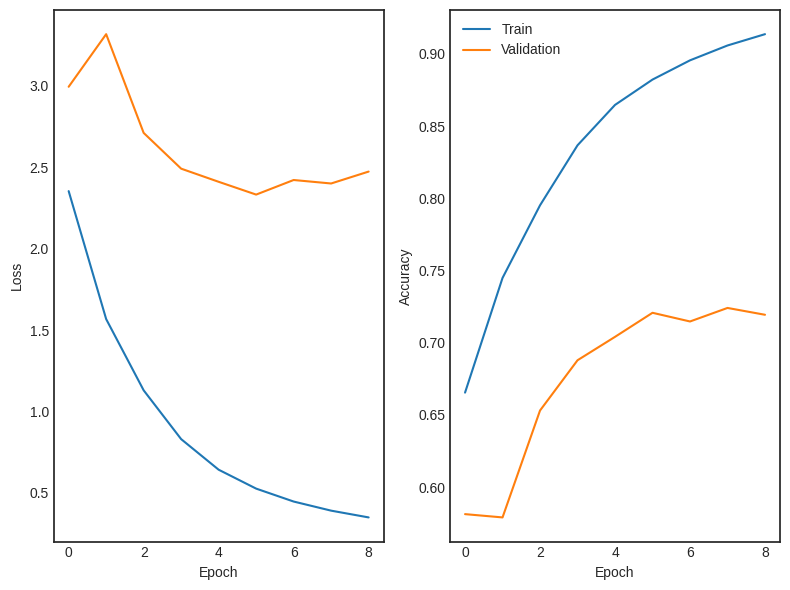

In [8]:
try: results
except NameError: results = None
if grading or not results:
    # Load the results
    with open(os.path.join(model_dir, 'seq2seq_translator_results.pkl'), 'rb') as file:
        metrics = pickle.load(file)
elif not grading and results:
    # Or get them from model training
    metrics = results.history

# Show best loss and accuracy
print(f"Train loss: {min(metrics['loss']):.3f}")
print(f"Train accuracy: {max(metrics['accuracy']):.3f}")
print(f"Best validation loss: {min(metrics['val_loss']):.3f}")
print(f"Best validation accuracy: {max(metrics['val_accuracy']):.3f}")

# Plot the training loss and accuracy
fig, ax = plt.subplots(1, 2, figsize=(8, 6), sharex=True, sharey=False)
ax[0].plot(metrics['loss'], label='Train Loss')
ax[0].plot(metrics['val_loss'], label='Validation Loss')
ax[0].set(xlabel='Epoch', ylabel='Loss')
ax[1].plot(metrics['accuracy'], label='Train Accuracy')
ax[1].plot(metrics['val_accuracy'], label='Validation Accuracy')
ax[1].set(xlabel='Epoch', ylabel='Accuracy')
plt.legend(['Train', 'Validation'])
plt.tight_layout()
plt.show()

## 1.4 Calculate BLEU and METEOR scores

[Bilingual Evaluation Understudy (BLEU)](https://aclanthology.org/P02-1040/), is a score for comparing a candidate translation of text to one or more reference translations.

- BLEU score is more precision based than recalled. In other words, it is based on evaluating whether all words in the generated candidate are in the reference that a manual evaluator comes up with. But it does not check if all words in reference are covered!

- BLEU score does not take into account semantic similarity. The BLEU score looks for exact word matches. But it does not consider the fact that a word such as red is close to the word scarlet for instance. For example, “the cat is on the mat” should be semantically similar to “the cat is over the mat”. However, “the cat is under the mat” does not mean the same thing! BLEU score fails here.

- Good matches often have clusters of words in candidate that match closely with clusters of words in the reference. BLEU score is not great with capturing this.

[METEOR](https://aclanthology.org/W05-0909/) evaluates a translation by computing a score based on explicit word-to-word matches between the translation and a given reference translation. If more than one reference translation is available, the translation is scored against each reference independently, and the best scoring pair is used.

Once the model is trained we can evaluate it by calculating the BLEU and METEOR scores. First we should load the weights of the best model found during training. As previously discussed, due to the length of training time it is **highly recommended you load the model provided**:

`seq2seq_translator.weights.h5`:
 - Vocabulary size = ~16k English and ~28k French
 - Max sequence length = 20
 - Embedding dimension = 100
 - LSTM units = 256
 - Epochs = ~10

In [9]:
# Load the model
model.load_weights(os.path.join(model_dir, 'seq2seq_translator.weights.h5'))
model.summary()

/opt/conda/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 33 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "seq2seq_attn"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Translator          │ (None, 20, 27962) │ 12,311,431 │ encoder_inputs[0… │
│ (Translator)        │                   │            │ decoder_inputs[0… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 12,311,431 (46.96 MB)

 Trainable params: 12,311,431 (46.96 MB)

 Non-trainable params: 0 (0.00 B)

Now create a list of reference (ground truth) and candidate (predicted) sequences:

1. Loop over each batch in the test data (we will use the validation set)

2. Use the model to generate predictions

3. Convert the predicted token ids back into words, and similarly for the actual translation

4. Calculate BLEU and METEOR for all the candidate and reference pairs

<div class="alert alert-danger" style="color:black"><b>Warning:</b> This cell is quite computationally expensive. It is strongly recommended you only run ~10-100 batches, just to get a picture of the BLEU and METEOR score.
</div>

In [ ]:
if not grading:
    candidates = []
    references = []
    special_tokens = ['<s>', '</s>', '<pad>']

    # Just make predictions on the first n batches
    num_batches = 10
    for i in range(num_batches):
        
        # Get the inputs and outputs
        inputs, outputs = val_generator[i]

        # Predict on the validation set
        predictions = model.predict(inputs, verbose=0)

        # Convert the predictions to ids
        predicted_ids = tf.argmax(predictions, axis=-1).numpy()

        # Get the predicted sentence and the reference sentence
        for j in range(predicted_ids.shape[0]):

            # Convert the ids to words
            predicted_sentence = [fr_vocab[i] for i in predicted_ids[j] if fr_vocab[i] not in special_tokens]
            candidates.append(predicted_sentence)

            reference_sentence = [fr_vocab[i] for i in outputs[j] if fr_vocab[i] not in special_tokens]
            references.append(reference_sentence)

    # Smoothing function accounts for cases where the candidate sentence is shorter than the reference sentence
    ch = SmoothingFunction().method7  # Chen and Cherry method

    # Cumulative - calculation of individual n-gram scores at all orders from 1 to n
    c_1g = corpus_bleu(references, candidates, weights=(1, 0, 0, 0), smoothing_function=ch)
    c_2g = corpus_bleu(references, candidates, weights=(0.5, 0.5, 0, 0), smoothing_function=ch)
    c_3g = corpus_bleu(references, candidates, weights=(0.33, 0.33, 0.33, 0), smoothing_function=ch)
    c_4g = corpus_bleu(references, candidates, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=ch)
    print(f"BLEU Cumulative 1-gram: {c_1g:.4f}, 2-gram: {c_2g:.4f}, 3-gram: {c_3g:.4f}, 4-gram: {c_4g:.4f}")

    meteor_scores = [round(meteor([references[i]], candidates[i]), 5) for i in range(len(references))]
    print(f"Completions METEOR: Mean={np.mean(meteor_scores):.4f}, Max={np.max(meteor_scores):.4f}, Min={np.min(meteor_scores):.4f}")

## 1.5 Translate text

Once the model is trained we can now use it to translate some text! First we should load the weights of the best model found during training. Then we can set choose a phrase for translation and (optionally) set the correct translation. Our `translate()` function can take care of the rest!

Input: I am a student.
Predicted translation: je suis etudiant .
Input sentence: I am a student.
Translation: Je suis un étudiant.
Predicted translation: je suis etudiant .


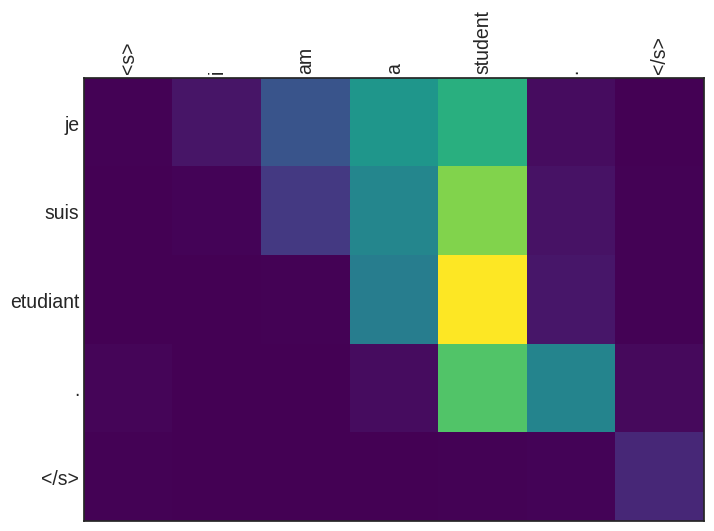

In [10]:
# Test the model on a sentence
input_sentence = "I am a student."
correct_translation = "Je suis un étudiant."

# Translate the sentence
predicted_translation, attn_fig = translator.translate(input_sentence)

print(f"Input sentence: {input_sentence}")
print(f"Translation: {correct_translation}")
print(f"Predicted translation: {predicted_translation}")

<div class="alert alert-success" style="color:black"><h3>Before you submit this notebook to NBGrader for marking:</h3> 

1. Make sure have completed all exercises marked by <span style="color:blue">**blue cells**</span>.
2. For automatically marked exercises ensure you have completed any cells with `# YOUR CODE HERE`. Then click 'Validate' button above, or ensure all cells run without producing an error.
3. For manually marked exercises ensure you have completed any cells with `"YOUR ANSWER HERE"`.
4. Ensure all cells are run with their output visible.
5. Fill in your student ID (**only**) below.
6. You should now **save and download** your work.

</div>

**Student ID:** 15006280
